# Statistical Mean Reversion

Mean reversion is a trading strategy positing that asset prices and returns tend to revert to their long-term mean or average level over time. Mathematically, such a continuous-time series is represented by an Ornstein-Uhlenbeck process, where the change in price series in the next period is proportional to the difference between the mean price and the current price. In contrast, a random walk, or Brownian motion, where current price movements are independent of historical data, lacks the "memory" of its previous states at any given moment in time. The mean-reverting characteristic of such time series can be leveraged to design and implement profitable trading strategies.

# Augmented Dickey-Fuller (ADF) Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a given time series is stationary or not. A stationary time series has properties that do not depend on the time at which the series is observed; specifically, its mean, variance, and autocorrelation structure remain constant over time. The ADF test is used to test for the presence of a unit root.

## Basic Model

The basic Dickey-Fuller test can be represented by the following autoregressive model:

$y_t = \rho y_{t-1} + \epsilon_t$

where:
- $y_t$ is the time series observation,
- $\epsilon_t$ is the white noise error term.

## Augmentation

To account for higher-order autoregressive processes and improve the test's robustness, the ADF test uses an augmented model that includes lagged differences of $y_t$:

$\Delta y_t = \alpha + \beta t + \rho y_{t-1} + \sum_{i=1}^p \phi_i \Delta y_{t-i} + \epsilon_t$

where:
- $\Delta y_t = y_t - y_{t-1}$ is the first difference of $y_t$,
- $\alpha$ is the constant term,
- $\beta t$ represents the trend term (optional),
- $\rho$ is the coefficient on the lagged level of the time series,
- $\phi_i$ are coefficients for the lagged differences,
- $p$ is the number of lagged differences included,
- $\epsilon_t$ is the error term.

## Hypotheses

- **Null Hypothesis (H0)**: $\rho = 0$. This implies that the time series has a unit root and is non-stationary.
- **Alternative Hypothesis (H1)**: $\rho < 0$. This implies that the time series is stationary.

## Test Statistic

The test statistic for the ADF test is derived from the estimated value of $\rho$. Specifically, we estimate the model and obtain the coefficient $\hat{\rho}$ on $y_{t-1}$. The test statistic is:

$\text{ADF Statistic} = \frac{\hat{\rho} - 1}{\text{SE}(\hat{\rho})}$

where $\text{SE}(\hat{\rho})$ is the standard error of the $\hat{\rho}$ estimate.

## Critical Values

The calculated ADF statistic is compared to critical values from the Dickey-Fuller distribution. These critical values vary depending on whether the model includes a constant, a trend, or neither.

## Decision Rule

- **If the ADF statistic is less than the critical value**: Reject the null hypothesis $H_0$, suggesting the time series is stationary.
- **If the ADF statistic is greater than the critical value**: Fail to reject the null hypothesis $H_0$, suggesting the time series is non-stationary.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import yfinance as yf
import arch.unitroot

# Define the ticker
ticker = "USDCAD=X"

# Download historical data for USD/CAD using yfinance
data = yf.download(ticker, start='2007-07-22', end='2012-03-28', interval='1d')['Close']

# Remove any NaN values
data = data.dropna()

# Perform the Augmented Dickey-Fuller test
adf = arch.unitroot.ADF(data,1)

# Print the summary of the test
print(adf.summary())


[*********************100%%**********************]  1 of 1 completed
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.822
P-value                         0.370
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# Hurst Exponent

The **Hurst exponent** ($H$) is a statistical measure used to determine the long-term memory of time series data. It helps identify whether a time series is **persistent**, **mean-reverting**, or exhibits **random walk behavior**. 


## Formula

The Hurst exponent is defined as:

$
E[R(n)/S(n)] = Cn^H
$

Where:
- $E[R(n)/S(n)]$ is the expected rescaled range (range of cumulative deviations divided by standard deviation) of the time series over $n$ periods.
- $C$ is a constant.
- $n$ is the time period.
- $H$ is the Hurst exponent, which lies in the range $0 \leq H \leq 1$.

## Interpretation

The value of the Hurst exponent indicates the nature of the time series:

- **$H = 0.5$**: The time series follows a random walk (i.e., no autocorrelation, purely stochastic process like Brownian motion).
- **$H < 0.5$**: The time series is **mean-reverting**. This suggests that if the time series has been increasing, it is likely to decrease in the future, and vice versa (negative autocorrelation).
- **$H > 0.5$**: The time series is **persistent**. This implies that trends in the data are likely to continue in the same direction (positive autocorrelation).

In [2]:
def hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    hurst_exponent = np.polyfit(np.log(lags), np.log(tau), 1)[0]
    return hurst_exponent

# Calculate Hurst Exponent
H = hurst_exponent(data.values)
print(f"Hurst exponent (H) = {H:.2f}")

Hurst exponent (H) = 0.47


# Half Life of Mean Reversion

The half-life of mean reversion helps in evaluating the practical applicability of mean-reversion trading strategies.

1. **Mean Reversion Model**:
   - The λ coefficient from the mean-reversion model can indicate how quickly a price series reverts to its mean. If λ is negative, it suggests mean reversion.

2. **Differential Form and Half-Life**:
   - The model in differential form is $ dy(t) = (\lambda y(t - 1) + \mu)dt + d\epsilon $.
   - The half-life of mean reversion, which is the time required for the price to revert halfway to its mean, is given by \($ -\frac{\log(2)}{\lambda} $\).

3. **Practical Implications**:
   - Positive λ means the series is not mean-reverting.
   - λ close to zero implies a long half-life, which may affect the profitability of trading strategies.
   - The half-life can guide the choice of look-back periods and other parameters in trading strategies.


In [3]:
import statsmodels.api as sm

def calculate_half_life(series):
    # Calculate the lagged series
    series_lag = series.shift(1)
    
    # Calculate the change in the series
    delta_series = series - series_lag
    
    # Remove missing values
    series_lag = series_lag[1:]
    delta_series = delta_series[1:]
    
    # Add a constant term to the lagged series
    series_lag_constant = sm.add_constant(series_lag)
    
    # Fit the AR(1) model
    model = sm.OLS(delta_series, series_lag_constant)
    results = model.fit()
    
    # Get the AR(1) coefficient
    theta = results.params.iloc[1]  # Use iloc to avoid the warning
    
    # Calculate the half-life
    half_life = -np.log(2) / theta
    
    return half_life

# Calculate half-life
halflife = calculate_half_life(data)
print("Half-Life of Mean Reversion:", halflife)

Half-Life of Mean Reversion: 124.4706025123989


# A linear Mean-Reverting Trading Strategy


## Overview

A linear mean-reverting trading strategy can be profitable if the price series is mean-reverting and its half-life is short enough for your trading horizon. This strategy involves trading based on the price’s deviation from its moving average, adjusted by the moving standard deviation.

## Strategy Description

1. **Calculate Normalized Deviation**:
   - Compute the deviation of the price from its moving average.
   - Normalize this deviation by dividing it by the moving standard deviation.

2. **Adjust Position**:
   - Maintain a number of units in the asset that is inversely proportional to the normalized deviation.

3. **Look-back Period**:
   - Set the look-back period for both the moving average and the moving standard deviation to equal the half-life of mean reversion.

## Rationale for Using Moving Averages and Standard Deviations

- **Stationarity and Mean**:
  - Even if a price series is stationary, the mean may change due to economic or corporate factors.
  - The standard deviation of a stationary series with 0 < H < 0.5 increases over time.

- **Adaptation**:
  - Moving averages and standard deviations help adapt to evolving mean and variance, capturing profit more effectively.



Cumulative PnL:
 Date
2007-07-23         NaN
2007-07-24         NaN
2007-07-25    0.003547
2007-07-26    0.003369
2007-07-27   -0.008654
                ...   
2012-03-21   -0.087536
2012-03-22   -0.086288
2012-03-23   -0.077381
2012-03-26   -0.079398
2012-03-27   -0.084577
Name: Close, Length: 1215, dtype: float64


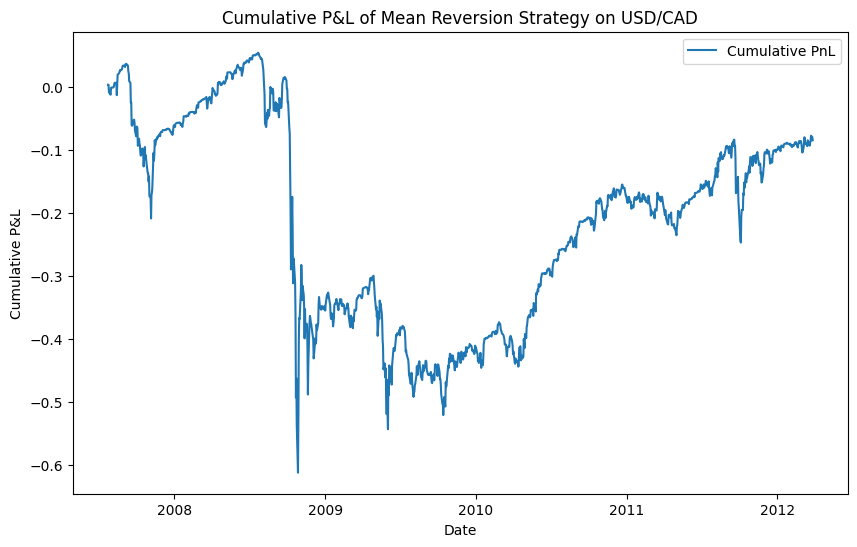

In [4]:
import statsmodels.tsa.stattools as ts

lookback = round(halflife)

# Moving average and moving standard deviation using rolling window
def movingAvg(series, window):
    return series.rolling(window=window, min_periods=1).mean()

def movingStd(series, window):
    return series.rolling(window=window, min_periods=1).std()

# Lag function to shift the series
def lag(series, periods=1):
    return series.shift(periods)

# Calculate the market value based on the Z-Score
mktVal = -(data - movingAvg(data, lookback)) / movingStd(data, lookback)

# Calculate the daily P&L
pnl = lag(mktVal, 1) * (data - lag(data, 1)) / lag(data, 1)

# Cumulative P&L
cumulative_pnl = pnl.cumsum()

# Output results
print("Cumulative PnL:\n", cumulative_pnl)

# Plot the cumulative PnL
plt.figure(figsize=(10, 6))
plt.plot(cumulative_pnl, label='Cumulative PnL')
plt.title('Cumulative P&L of Mean Reversion Strategy on USD/CAD')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()
